<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Dataset-handling" data-toc-modified-id="Dataset-handling-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Dataset handling</a></span></li><li><span><a href="#Simple-psychometric-fits" data-toc-modified-id="Simple-psychometric-fits-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Simple psychometric fits</a></span><ul class="toc-item"><li><span><a href="#Percent-Correct" data-toc-modified-id="Percent-Correct-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Percent Correct</a></span></li><li><span><a href="#Proportion-Choose-Right" data-toc-modified-id="Proportion-Choose-Right-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Proportion Choose Right</a></span></li></ul></li><li><span><a href="#Simplest-effects-of-CP-on-percent-correct" data-toc-modified-id="Simplest-effects-of-CP-on-percent-correct-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Simplest effects of CP on percent correct</a></span></li><li><span><a href="#Logistic-regression" data-toc-modified-id="Logistic-regression-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Logistic regression</a></span><ul class="toc-item"><li><span><a href="#Single-predictor" data-toc-modified-id="Single-predictor-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Single predictor</a></span><ul class="toc-item"><li><span><a href="#Signed-coherence" data-toc-modified-id="Signed-coherence-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Signed coherence</a></span></li></ul></li><li><span><a href="#More-predictors" data-toc-modified-id="More-predictors-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>More predictors</a></span></li></ul></li></ul></div>

<!--
IRdisplay::display_html(file='../code_hiding.html')
if the line above generates an error, it could be due to this:
https://github.com/IRkernel/IRdisplay/issues/41
In the meantime, the code below is enough; it works on nbviewer but not on the notebook directly
-->

<script>
  code_show=true;
  function code_toggle() {
    if (code_show){
      $('div.input').hide();
    } else {
      $('div.input').show();
    }
    code_show = !code_show
  } 
  $( document ).ready(code_toggle);
</script>
<font size=4>
<a href="javascript:code_toggle()">Toggle ON/OFF</a>
code cells.
</font>

# Fitting psychometric functions

This notebook analyzes data from `Pilot 13-14` datasets.

In [2]:
library(data.table)
library(ggplot2)        
source('../../R/R_functions.r')

In [3]:
# define constants for notebook

# todo: the following is VERY INELEGANT!
psubj13 <- c(37,2.5,0.5,0.001)
names(psubj13) <- c('threshold','slope','guess','lapse')
psubj14 <- c(23,2.5,0.5,0.001)
names(psubj14) <- c('threshold','slope','guess','lapse')
QuestParams <- list(psubj13, psubj14)
names(QuestParams) <- c('13', '14')

# recall, to access threshold of subject 13, type
# th13 <- QuestParams[['13']]['threshold']

## Dataset handling

Let's load and inspect the dataset.

In [4]:
# load dataset
data <- fread('../../data/Pilot13-14/psychophysical_data.csv')
data[,presenceCP:=as.factor(presenceCP)]
data[,choice:=as.factor(choice)]

In [5]:
data[,signedCohLast := coherence]
data[signedCoherence < 0, signedCohLast := signedCoherence]
data[choice=="left" & presenceCP=="yes" & correct, signedCohLast:= - coherence]
data[choice=="right" & presenceCP=="yes" & !correct, signedCohLast:= - coherence]

In [6]:
str(data)

Classes ‘data.table’ and 'data.frame':	977 obs. of  12 variables:
 $ pilotID        : int  13 13 13 13 13 13 13 13 13 13 ...
 $ taskID         : int  1 1 1 1 1 1 1 1 1 1 ...
 $ validTrialCount: int  1 2 3 4 5 6 7 8 9 10 ...
 $ choice         : Factor w/ 2 levels "left","right": 2 1 1 2 2 1 2 1 2 2 ...
 $ correct        : logi  TRUE FALSE TRUE TRUE TRUE TRUE ...
 $ presenceCP     : Factor w/ 2 levels "no","yes": 1 1 1 1 1 1 1 1 1 1 ...
 $ viewingDuration: num  0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 ...
 $ signedCoherence: num  50 50 -57 57 56 -56 56 -55 55 55 ...
 $ coherence      : num  50 50 57 57 56 56 56 55 55 55 ...
 $ choice_time    : num  0.363 0.833 0.578 0.572 0.633 ...
 $ exactVD        : num  0.22 0.203 0.203 0.219 0.219 ...
 $ signedCohLast  : num  50 50 -57 57 56 -56 56 -55 55 55 ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [7]:
print('first 6 rows of data.table')
head(data)

[1] "first 6 rows of data.table"


pilotID,taskID,validTrialCount,choice,correct,presenceCP,viewingDuration,signedCoherence,coherence,choice_time,exactVD,signedCohLast
13,1,1,right,TRUE,no,0.2,50,50,0.3633654,0.2203390,50
13,1,2,left,FALSE,no,0.2,50,50,0.8330632,0.2033898,50
13,1,3,left,TRUE,no,0.2,-57,57,0.5782815,0.2033898,-57
13,1,4,right,TRUE,no,0.2,57,57,0.5724611,0.2193786,57
13,1,5,right,TRUE,no,0.2,56,56,0.6325272,0.2188400,56
13,1,6,left,TRUE,no,0.2,-56,56,0.6130831,0.2033898,-56


## Simple psychometric fits 

### Percent Correct

Is the percent correct as a function of coherence value in the task node similar to the one estimated in the Quest node?

In [8]:
# steps
# 1. For each subject, get parameters of psychometric curve estimated by Quest
# 2. plot the curve
# 3. overlay data from task node, for appropriate viewing duration
# 4. overlay theoretical curve corresponding to the fitted logistic regression
# 5. plot everything

# The final plot should use a single data.table
# data[taskID==2]
# progress
# 1. complete
# 2. complete
# 3. complete

In [8]:
subj <- '13'
x <- seq(100)
psychometric <- psi_corr(weibull, QuestParams[[subj]])
y <- psychometric(x)

questCurve <- data.table(x=x, y=y)

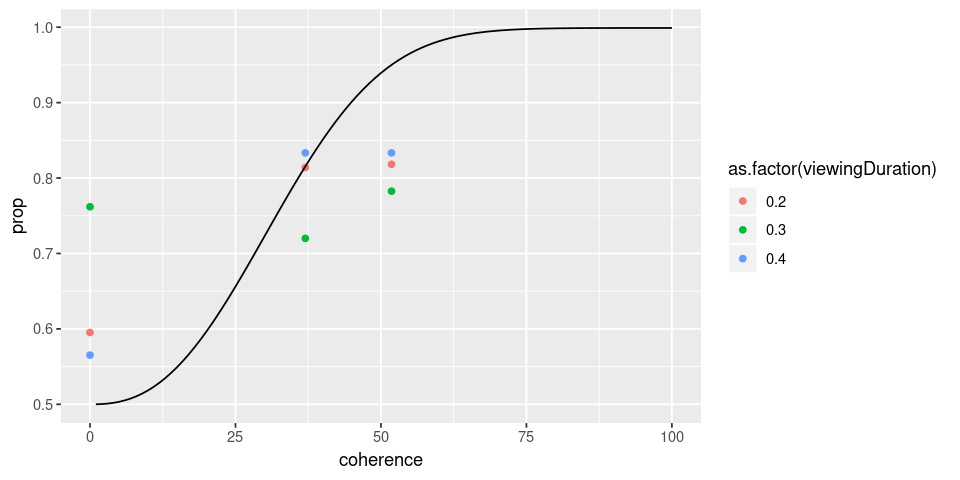

In [9]:
# control output figure size
options(repr.plot.width=8, repr.plot.height=4)
ggplot(data[pilotID==subj & taskID==2 & presenceCP=='no',
            .(prop=sum(correct==TRUE)/.N),by=.(coherence, viewingDuration)], aes(x=coherence, y=prop)) +
        geom_point(aes(col=as.factor(viewingDuration))) + 
        geom_line(aes(x=x, y=y), data=questCurve)

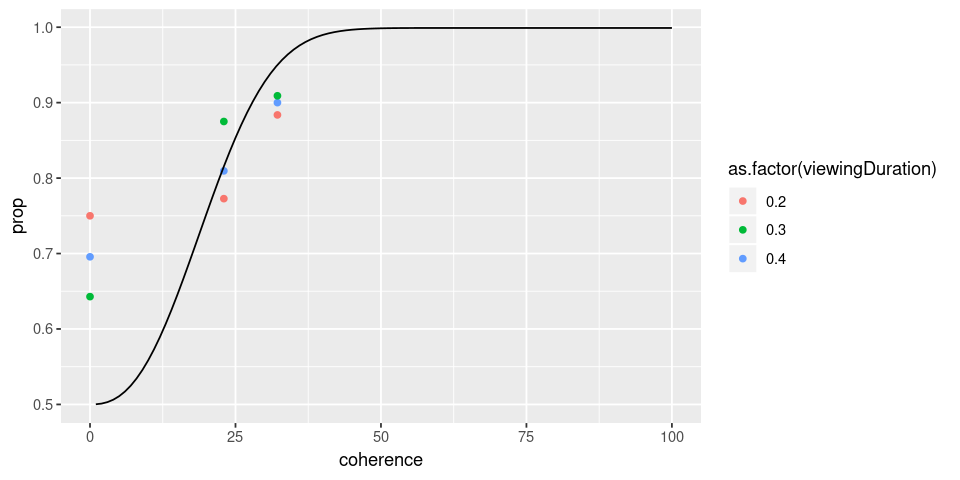

In [10]:
subj <- '14'
x <- seq(100)
psychometric <- psi_corr(weibull, QuestParams[[subj]])
y <- psychometric(x)

questCurve <- data.table(x=x, y=y)
ggplot(data[pilotID==subj & taskID==2 & presenceCP=='no',
            .(prop=sum(correct==TRUE)/.N),by=.(coherence, viewingDuration)], aes(x=coherence, y=prop)) +
        geom_point(aes(col=as.factor(viewingDuration))) + 
        geom_line(aes(x=x, y=y), data=questCurve)

### Proportion Choose Right

Let's fit simple logistic models, grouping by *subject and viewing duration*. 

In [11]:
# for an explanation of masked objects, see here:
# https://stackoverflow.com/a/39137111
library(quickpsy)

Loading required package: DEoptim
Loading required package: parallel

DEoptim package
Differential Evolution algorithm in R
Authors: D. Ardia, K. Mullen, B. Peterson and J. Ulrich

Loading required package: dplyr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, first, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘quickpsy’

The following object is masked from ‘package:stats’:

    deviance



In [15]:
data[,facVD:=as.factor(viewingDuration)]

In [18]:
data[,numChoice:=0]
data[choice=='right',numChoice:=1]

In [19]:
str(data[taskID==2])

Classes ‘data.table’ and 'data.frame':	784 obs. of  14 variables:
 $ pilotID        : int  13 13 13 13 13 13 13 13 13 13 ...
 $ taskID         : int  2 2 2 2 2 2 2 2 2 2 ...
 $ validTrialCount: int  1 2 3 4 5 6 7 8 9 10 ...
 $ choice         : Factor w/ 2 levels "left","right": 2 2 2 2 2 2 1 2 1 1 ...
 $ correct        : logi  TRUE TRUE TRUE TRUE TRUE TRUE ...
 $ presenceCP     : Factor w/ 2 levels "no","yes": 2 1 1 1 1 1 1 2 2 1 ...
 $ viewingDuration: num  0.4 0.2 0.2 0.4 0.3 0.4 0.2 0.3 0.4 0.3 ...
 $ signedCoherence: num  NA 37 51.8 51.8 37 ...
 $ coherence      : num  37 37 51.8 51.8 37 ...
 $ choice_time    : num  0.452 1.788 0.402 0.34 0.347 ...
 $ exactVD        : num  0.405 0.203 0.203 0.424 0.322 ...
 $ signedCohLast  : num  37 37 51.8 51.8 37 ...
 $ facVD          : Factor w/ 3 levels "0.2","0.3","0.4": 3 1 1 3 2 3 1 2 3 2 ...
 $ numChoice      : num  1 1 1 1 1 1 0 1 0 0 ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [20]:
fit <- quickpsy(data[taskID==2], signedCohLast, numChoice, grouping=.(pilotID, facVD))

In [21]:
names(fit)

[1] "x"                    "k"                    "n"                   
 [4] "guess"                "lapses"               "averages"            
 [7] "groups"               "funname"              "log"                 
[10] "psyfunguesslapses"    "limits"               "pariniset"           
[13] "parini"               "optimization"         "par"                 
[16] "pariniset"            "ypred"                "curves"              
[19] "sse"                  "thresholds"           "logliks"             
[22] "loglikssaturated"     "deviance"             "avbootstrap"         
[25] "parbootstrap"         "logliksboot"          "logliksbootsaturated"
[28] "devianceboot"         "aic"                  "parcomparisons"      
[31] "curvesbootstrap"      "thresholdsbootstrap"  "thresholdcomparisons"

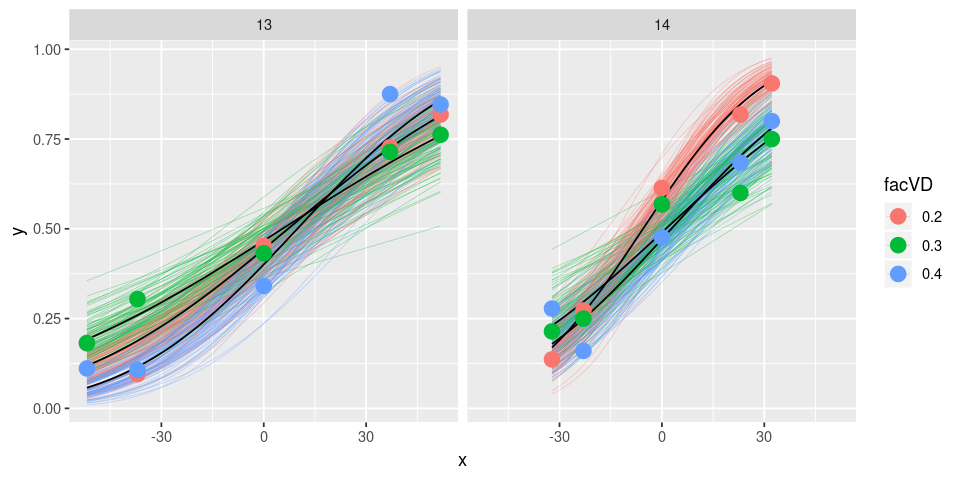

In [22]:
# from http://dlinares.org/basicsquickpsy.html
ggplot() +
 facet_wrap(~pilotID) +
 geom_line(data = fit$curvesbootstrap, aes(x = x, y = y, color = facVD, 
                   group=paste(sample,facVD)), lwd = .2, alpha = .4) +   
 geom_line(data = fit$curves, aes(x = x, y = y, group = facVD), 
           color = 'black') +
 geom_point(data = fit$averages, aes(x = signedCohLast, y = prob, color = facVD), size = 4)

## Simplest effects of CP on percent correct

**Question:** Does the physical presence of a CP affect state inference?  
**Hypotheses:** At fixed viewing duration the (physical) presence of a CP will decrease accuracy.  
**Method:** Hypothesis testing, i.e. is the difference in percent correct between the `CP` and `nonCP` conditions significantly different from 0?

Let's build a contingency table and perform [Fisher's exact test](https://en.wikipedia.org/wiki/Fisher%27s_exact_test#Example).

In [23]:
subj <- '13'
task <- '2'
vd <- .4
maxCoh <- as.numeric(data[pilotID==subj & taskID==task, max(coherence)])
cat('max coh for subject', subj, 'on task', task, 'is', maxCoh, '\n')
contingency <- as.matrix(data[viewingDuration==vd & pilotID==subj & taskID==task & coherence>0 & coherence < maxCoh, 
                              .(Corrrect=sum(correct),Incorrect=sum(!correct)), by=presenceCP], rownames=TRUE)
t(contingency)
fisher.test(t(contingency)) # two-sided test; see ?fisher.test for help

max coh for subject 13 on task 2 is 51.81503 


,yes,no
Corrrect,24,15
Incorrect,2,3



	Fisher's Exact Test for Count Data

data:  t(contingency)
p-value = 0.3859
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  0.2398253 31.2533056
sample estimates:
odds ratio 
  2.351029 


In [24]:
subj <- '14'
maxCoh <- as.numeric(data[pilotID==subj & taskID==task, max(coherence)])
cat('max coh for subject', subj, 'on task', task, 'is', maxCoh, '\n')
contingency <- as.matrix(data[viewingDuration==vd & pilotID==subj & taskID==task & coherence>0 & coherence < maxCoh, 
                              .(Corrrect=sum(correct),Incorrect=sum(!correct)), by=presenceCP], rownames=TRUE)
t(contingency)
fisher.test(t(contingency)) # two-sided test; see ?fisher.test for help

max coh for subject 14 on task 2 is 32.20934 


,yes,no
Corrrect,17,17
Incorrect,6,4



	Fisher's Exact Test for Count Data

data:  t(contingency)
p-value = 0.724
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.1172459 3.4452526
sample estimates:
odds ratio 
 0.6728156 


We conclude that the test is not significant, i.e., we do **not** reject the null hypothesis that percent correct is the same with and without change points.

## Logistic regression

### Single predictor

#### Signed coherence
<a id="cohpred"></a>

We start super simple with the equation:
$$\log\frac{p_i}{1-p_i}=\beta_0+\beta_1x^\text{sc}_i$$
where $p_i$ is the proportion of right choices at stimulus level $i$ and $x^\text{sc}$ is the signed coherence value.
The current data (Pilot 11) has 11 stimulus levels, which correspond to the 11 signed coherence values: 

In [25]:
subj <- '13'
task <- '2'

In [26]:
unique(data[pilotID==subj & taskID==task & order(signedCohLast),.(signedCohLast)][,signedCohLast])

[1]  37.00000  51.81503   0.00000 -51.81503 -37.00000


Call:
glm(formula = choice ~ signedCohLast, family = binomial(), data = data[pilotID == 
    subj & taskID == task])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8266  -1.0684  -0.5078   0.8028   2.0553  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -0.261997   0.118744  -2.206   0.0274 *  
signedCohLast  0.033219   0.003624   9.167   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 539.34  on 391  degrees of freedom
Residual deviance: 428.71  on 390  degrees of freedom
AIC: 432.71

Number of Fisher Scoring iterations: 3



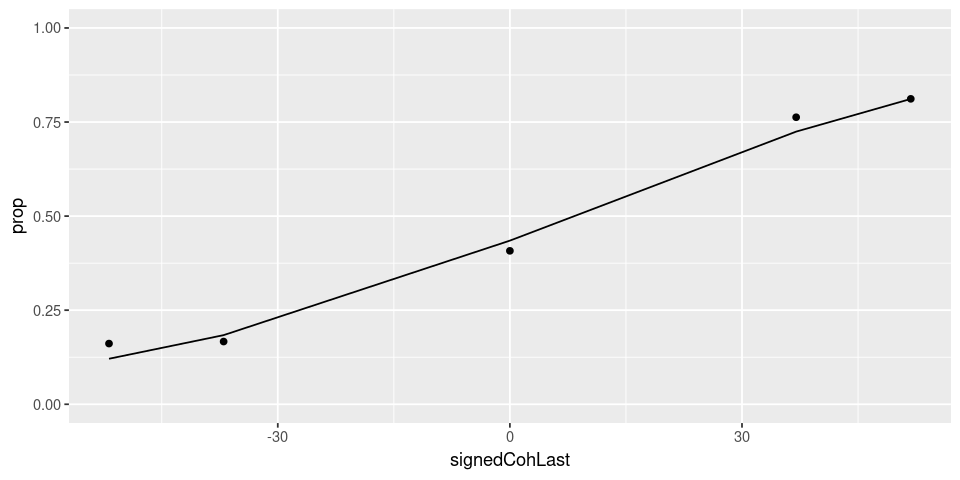

In [27]:
fit_logistic_single_pred(data[pilotID==subj & taskID==task], choice, "right", signedCohLast)

In [28]:
subj <- '14'
unique(data[pilotID==subj & taskID==task & order(signedCohLast),.(signedCohLast)][,signedCohLast])

[1]   0.00000 -32.20934  32.20934  23.00000 -23.00000


Call:
glm(formula = choice ~ signedCohLast, family = binomial(), data = data[pilotID == 
    subj & taskID == task])

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.85048  -0.79604  -0.01596   1.15428   1.80190  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)   0.054682   0.113557   0.482     0.63    
signedCohLast 0.045280   0.005422   8.351   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 543.43  on 391  degrees of freedom
Residual deviance: 457.90  on 390  degrees of freedom
AIC: 461.9

Number of Fisher Scoring iterations: 4



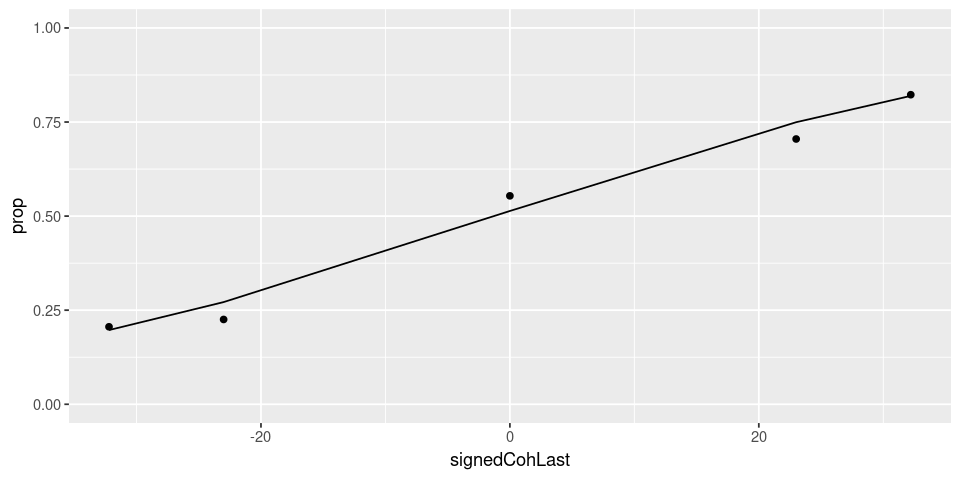

In [29]:
fit_logistic_single_pred(data[pilotID==subj & taskID==task], choice, "right", signedCohLast)

### More predictors